In [80]:
from funcs import *
from tqdm import tqdm
import matplotlib
%matplotlib widget

In [81]:
@jit(nopython=True)
def F(u):
    # l = 2.0
    # return u**l
    # return 1.0
    # return 0.0
    return np.square(u)
    # return 80.0*10**6
    # return 10.0
    # return 0.0

@jit(nopython=True)
def leftGU(x):
    return 0.0

@jit(nopython=True)
def rightGU(x):
    return 0.0

@jit(nopython=True)
def derivateGU(x,xgrid):
    if x == xgrid[0]:
        return 0.0
    if x == xgrid[-1]:
        return 0.0
    if x == xgrid[int(len(xgrid)/2)]:
        return 0.0
    if x == xgrid[int(len(xgrid)*1/4)]:
        return 0.0
    if x == xgrid[int(len(xgrid)*7/8)]:
        return 0.0
    
    return 1.0

@jit(nopython=True)
def GU(x,xgrid):
    if x > xgrid[int(len(xgrid)*1/4)] and x < xgrid[int(len(xgrid)/2)]:
        return 0.0
    return 1.0
    


NU_ = Distrib(make_func("triangle_m_f", [-0.5,0.0,0.5]), supp_of_func=(-0.5,0.0,0.5))

def NU(x,xgrid):
    # return NU_(x)  
    # return 0.0
    # mu = xgrid[int(len(xgrid)/2)]
    # sigma = 0.05
    # return np.exp(-0.5*np.square((x-mu)/sigma))*10.0

    
    # print(int(len(xgrid)/2))
    # print(x)
    # if x == xgrid[int(len(xgrid)/2)]:
    #     return 10.0
    # else:
    #     return 0.0

    return np.abs(np.cos(10*x))

@jit(nopython =True)
def D(x, u):
    mu1 = 0.25
    sigma = 0.05
    mu2 = -0.25
    return u**2.0*(1.0 - np.exp(-0.5*np.square((x-mu1)/sigma)))*(1.0 - np.exp(-0.5*np.square((x-mu2)/sigma)))
    # return u**2.0*np.abs(np.cos(x*10.0))+0.1
    # return 1.0


@jit(nopython=True)
def K(xl,xr,ul,ur):
    return 0.5*(D(xl,ul)+D(xr,ur))

@jit(nopython=True)
def phi(x, u_next_i, u_i):
    return 0.5*(F(u_next_i)+F(u_i))


In [82]:
@jit(nopython = True)
def solve(Nx,Nt,hx,tau,t,x,u_,eps=0.01):
    u = np.copy(u_)
    Nx = len(x)
    B = np.zeros(shape=(Nx,))
    A = np.zeros(shape=(Nx, Nx))
    end_ = False
    for k in range(Nt-1):
        u_s = np.copy(u[k])        
        for s in range(200):
            A[0][0] = -1.0/hx
            A[0][1] = 1.0/hx
            A[Nx-1][Nx-1] = 1.0/hx 
            A[Nx-1][Nx-2] = -1.0/hx
            for i in range(1,Nx-1):
                if derivateGU(x[i],x) == 0.0:
                    A[i][i-1] = 0.0
                    A[i][i]   =  -1.0/hx
                    A[i][i+1] = 1.0/hx
                    if i!=1 and GU(x[i-1],x) != 0.0:
                        A[i-1][i-2] = 0.0
                        A[i-1][i-1]   =  -1.0/hx
                        A[i-1][i] = 1.0/hx
                elif GU(x[i],x) ==0.0:
                    A[i][i] = 1.0
                else:
                    A[i][i-1] = 1.0/(4.0*hx**2)*D(x[i+1],u_s[i+1]) - 1.0/(4.0*hx**2)*D(x[i-1],u_s[i-1]) - 1.0/hx**2*D(x[i],u_s[i])
                    A[i][i]   = 1.0/tau+2.0/(hx**2)*D(x[i],u_s[i])
                    A[i][i+1] = -1.0/(4.0*hx**2)*D(x[i+1],u_s[i+1]) + 1.0/(4.0*hx**2)*D(x[i-1],u_s[i-1]) - 1.0/hx**2*D(x[i],u_s[i])
            
            B[0] = derivateGU(x[0],x)
            B[Nx-1] = derivateGU(x[Nx-1],x)
            for i in range(1,Nx-1):
                if derivateGU(x[i],x) == 0.0:
                    B[i] = 0.0
                    if i!=1 and GU(x[i-1],x) != 0.0:
                        B[i-1]=0.0
                elif GU(x[i],x) ==0.0:
                    B[i] = 0.0
                else:
                    B[i] = (F(u_s[i])+1.0/tau*u[k][i])*GU(x[i],x)
            # try:
            # u_s_new = np.matmul(np.linalg.inv(A),B)
            u_s_new = progonka(A,B)
            distance_ = np.max(np.abs(u_s_new-u_s))
            if distance_ < eps:
                u_s = u_s_new
                end_ = True
                break
            u_s = np.copy(u_s_new)
            # except Exception as error:
            #     print(error)
            #     end_ = True
            #     break
        if np.sum(np.isnan(u_s)) > 0 or np.sum(np.isinf(u_s)) > 0 or np.sum(u_s < 0.0) > 0:
            end_ = True
        if end_:
            return u[:k+1]
        u[k+1] = np.copy(u_s)
    return u

@jit(nopython = True)
def balance_solve(Nx,Nt,hx,tau,t,x,u_,eps=0.01):
    u = np.copy(u_)
    Nx = len(x)
    B = np.zeros(shape=(Nx,))
    A = np.zeros(shape=(Nx, Nx))
    end_ = False
    for k in range(Nt-1):
        u_s = np.copy(u[k])        
        for s in range(200):
            A[0][0] = -1.0/hx
            A[0][1] = 1.0/hx
            A[Nx-1][Nx-1] = 1.0/hx 
            A[Nx-1][Nx-2] = -1.0/hx
            # A[0][0] = 1.0
            # A[0][1] = 0.0
            # A[Nx-1][Nx-1] = 1.0 
            # A[Nx-1][Nx-2] = 0.0 
            for i in range(1,Nx-1):
                if derivateGU(x[i],x) == 0.0:
                    A[i][i-1] = 0.0
                    A[i][i]   =  -1.0/hx
                    A[i][i+1] = 1.0/hx
                    if i!=1 and GU(x[i-1],x) != 0.0:
                        A[i-1][i-2] = 0.0
                        A[i-1][i-1]   =  -1.0/hx
                        A[i-1][i] = 1.0/hx
                elif GU(x[i],x) ==0.0:
                    A[i][i] = 1.0
                else:
                    A[i][i-1] = -1.0/(hx**2)*K(x[i-1],x[i],u_s[i-1],u_s[i])
                    A[i][i]   = 1.0/tau+1.0/(hx**2)*K(x[i-1],x[i],u_s[i-1],u_s[i])+1.0/(hx**2)*K(x[i],x[i+1],u_s[i],u_s[i+1])
                    A[i][i+1] = -1.0/(hx**2)*K(x[i],x[i+1],u_s[i],u_s[i+1])
            B[0] = derivateGU(x[0],x)
            B[Nx-1] = derivateGU(x[Nx-1],x)
            for i in range(1,Nx-1):
                if derivateGU(x[i],x) == 0.0:
                    B[i] = 0.0
                    if i!=1 and GU(x[i-1],x) != 0.0:
                        B[i-1]=0.0
                elif GU(x[i],x) ==0.0:
                    B[i] = 0.0
                else:
                    B[i] = (phi(x[i],u_s[i],u[k][i])+1.0/tau*u[k][i])*GU(x[i],x)
            u_s_new = progonka(A,B)
            distance_ = np.max(np.abs(u_s_new-u_s))
            if distance_ < eps:
                u_s = u_s_new
                end_ = True
                break
            u_s = np.copy(u_s_new)
        if np.sum(np.isnan(u_s)) > 0 or np.sum(np.isinf(u_s)) > 0 or np.sum(u_s < 0.0) > 0:
            end_ = True
        if end_:
            return u[:k+1]
        u[k+1] = np.copy(u_s)
    return u

In [83]:
hx = 0.01
ax= -1.0
bx = 1.0
Nx=  int((bx-ax)/hx)+1
xgrid = np.linspace(ax,bx,num=Nx)
tau = 0.01
T = 1.0
t0 = 0.0
Nt = int((t0+T-t0)/tau) + 1
tgrid = np.linspace(start=t0, stop=t0+T,num=Nt)
t = np.copy(tgrid)
x = np.copy(xgrid)
u = np.zeros(shape=(len(tgrid),len(xgrid)))

In [84]:
for i in range(len(x)):
    u[0][i] = NU(x[i],x)
    # u[0][i] = 2.0


In [85]:
# u = solve(Nx,Nt,hx,tau,t,x,u,eps=0.0)
u = balance_solve(Nx,Nt,hx,tau,t,x,u,eps=0.0)

In [86]:
last_iter = 0
for i in range(len(u)):
    if np.sum(np.isnan(u[i])) > 0 or np.sum(np.isinf(u[i])) > 0:
        last_iter = i-1
        break
    last_iter += 1
print(last_iter, len(t))

101 101


/tmp/ipykernel_36545/3315030933.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()
100%|██████████| 99/99 [00:00<00:00, 178.73it/s]

0.0


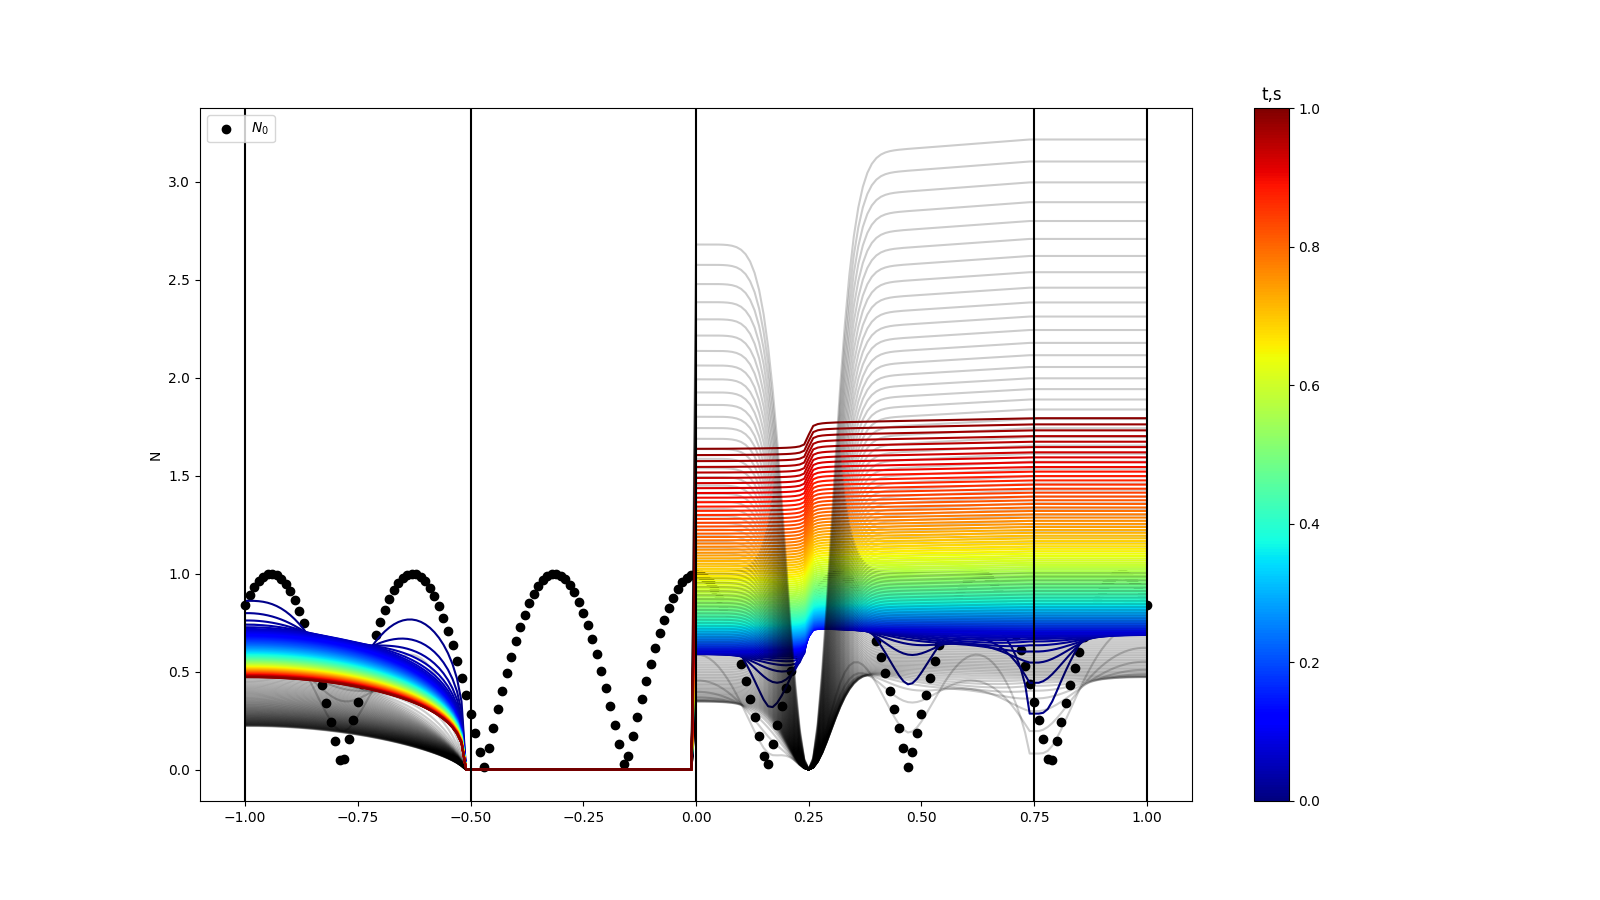

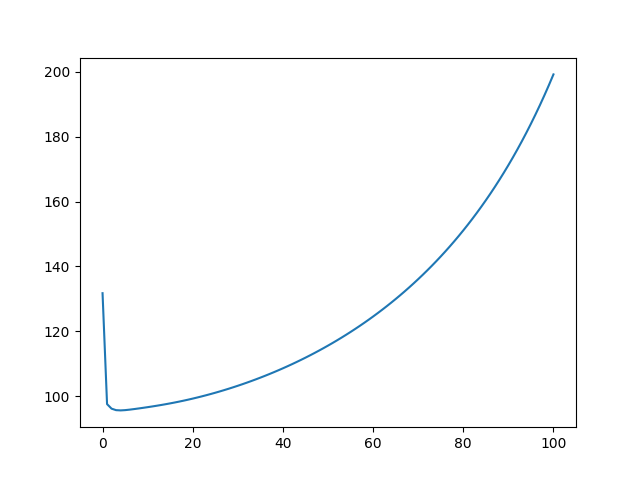

In [87]:
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
n_lines = last_iter
# n_lines = len(u)
# c = np.arange(1, n_lines+1)
c = np.copy(tgrid[:last_iter+1])
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap= matplotlib.cm.jet
m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
ax.scatter(xgrid, u[0],color='k',label=r'$N_{0}$')
for i in tqdm(range(1,int(n_lines)-1)):
    ax.plot(xgrid, u[i],color= m.to_rgba(tgrid[i]))
    ax.plot(xgrid, [D(x[j],u[i][j]) for j in range(len(x))],c='k',alpha=0.2)
for i in range(len(x)):
    if derivateGU(x[i],x) == 0.0:
        ax.axvline(x[i],c='k')
# ax.set_yscale('symlog')
# ax.set_yscale('log')
clb = fig.colorbar(m, ax=ax)
clb.ax.set_title('t,s')
ax.set_ylabel('N')
ax.legend()
print(np.min(u))
fig,ax = plt.subplots()
ax.plot(np.arange(len(u)), [np.sum(el) for el in u])
# ax.set_title(r'$k(x,u) = 1-e^{-0.5 (\frac{x-\mu}{\sigma})^2}+0.1 \cdot u$', y=-0.1)